# ¿Cuál es un mejor plan?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de los planes genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [1]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math as mt
from scipy import stats as st
import seaborn as sns

## Cargar los datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
plans = pd.read_csv('/datasets/megaline_plans.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
calls = pd.read_csv('/datasets/megaline_calls.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
users = pd.read_csv('/datasets/megaline_users.csv')

## Preparar los datos

- Al haber observado (inicialmente) las diferentes categorias incorrectas, procedo a corregir los tipos de datos datetime necesarios, para facilitar el proceso.

In [3]:
calls['call_date'] = pd.to_datetime(calls['call_date'])
internet['session_date'] = pd.to_datetime(internet['session_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])

## Planes

In [4]:
# Imprime la información general/resumen sobre el DataFrame de los planes
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [5]:
# Imprime una muestra de los datos para los planes
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Usuarios

In [6]:
# Imprime la información general/resumen sobre el DataFrame de los usuarios
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


reg_date al igual que churn_date fueron modificados de object a datetime

In [7]:
# Imprime una muestra de los datos para los usuarios
users.head(10)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaT
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,NaT
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaT
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,NaT


### Corregir datos

In [8]:
users.isna().sum()

user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64

In [9]:
users.isna().sum() * 100/len(users)

user_id        0.0
first_name     0.0
last_name      0.0
age            0.0
city           0.0
reg_date       0.0
plan           0.0
churn_date    93.2
dtype: float64

In [10]:
users.duplicated().sum()

0

In [11]:
(len(users) - users['churn_date'].isna().sum())/len(users) * 100

6.800000000000001

In [12]:
users['has_churned'] = (~pd.isnull(users['churn_date'])).astype(int)

In [13]:
users['has_churned'].value_counts()

0    466
1     34
Name: has_churned, dtype: int64

- Parece ser que el 93,2%(466 clientes) siguen con sus servicios activos, y el restante que es el 6,8%(34 clientes) han cancelado sus servicios.

In [14]:
users['user_id'].nunique() == len(users)

True

In [15]:
users['city'] = users['city'].str.lower()
users['first_name'] = users['first_name'].str.lower()
users['last_name'] = users['last_name'].str.lower()

In [16]:
users['made_calls'] = np.where(users['user_id'].isin(calls['user_id']) == True, 1, 0)

In [17]:
users.sample(10)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,has_churned,made_calls
403,1403,jae,gardner,27,"washington-arlington-alexandria, dc-va-md-wv msa",2018-02-06,ultimate,NaT,0,1
228,1228,jude,hale,26,"detroit-warren-dearborn, mi msa",2018-04-15,surf,NaT,0,1
302,1302,leonila,morris,62,"rochester, ny msa",2018-01-21,surf,NaT,0,1
443,1443,genaro,quinn,58,"atlanta-sandy springs-roswell, ga msa",2018-03-11,surf,NaT,0,1
255,1255,kennith,rowland,22,"oklahoma city, ok msa",2018-08-01,ultimate,NaT,0,1
183,1183,jermaine,gallegos,71,"chicago-naperville-elgin, il-in-wi msa",2018-07-20,surf,NaT,0,1
355,1355,digna,tyson,57,"los angeles-long beach-anaheim, ca msa",2018-10-07,surf,NaT,0,1
97,1097,deandre,powell,27,"washington-arlington-alexandria, dc-va-md-wv msa",2018-02-26,surf,NaT,0,1
9,1009,gerry,little,19,"san jose-sunnyvale-santa clara, ca msa",2018-04-22,surf,NaT,0,1
328,1328,tamesha,huber,20,"minneapolis-st. paul-bloomington, mn-wi msa",2018-02-10,surf,NaT,0,1


In [18]:
users['made_calls'].value_counts()

1    481
0     19
Name: made_calls, dtype: int64

## Llamadas

In [19]:
# Imprime la información/resumen general sobre el DataFrame de las llamadas
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


- call_date fue modificado de object a datetime

In [20]:
# Imprime una muestra de datos para llamadas
calls.head(10)

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22
5,1000_388,1000,2018-12-31,2.20
6,1000_510,1000,2018-12-27,5.75
7,1000_521,1000,2018-12-28,14.18
8,1000_530,1000,2018-12-28,5.77
9,1000_544,1000,2018-12-26,4.40


### Corregir datos

In [21]:
calls.describe(include='all')

/tmp/ipykernel_121/3291137240.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  calls.describe(include='all')


,id,user_id,call_date,duration
count,137735,137735.000000,137735,137735.000000
unique,137735,NaN,351,NaN
top,1042_374,NaN,2018-12-27 00:00:00,NaN
freq,1,NaN,1091,NaN
first,NaN,NaN,2018-01-15 00:00:00,NaN
last,NaN,NaN,2018-12-31 00:00:00,NaN
mean,NaN,1247.658046,NaN,6.745927
std,NaN,139.416268,NaN,5.839241
min,NaN,1000.000000,NaN,0.000000
25%,NaN,1128.000000,NaN,1.290000


In [22]:
calls.isna().sum()

id           0
user_id      0
call_date    0
duration     0
dtype: int64

In [23]:
calls.duplicated().sum()

0

In [24]:
calls['id'].nunique() == len(calls)

True

In [25]:
calls['user_id'].nunique()

481

- Existen 481 usuarios unicos que realizan o han realizado llamadas

In [26]:
calls['day'] = calls['call_date'].dt.day_name()
calls['month'] = calls['call_date'].dt.month
calls['year'] = calls['call_date'].dt.year

In [27]:
calls.head(10)

,id,user_id,call_date,duration,day,month,year
0,1000_93,1000,2018-12-27,8.52,Thursday,12,2018
1,1000_145,1000,2018-12-27,13.66,Thursday,12,2018
2,1000_247,1000,2018-12-27,14.48,Thursday,12,2018
3,1000_309,1000,2018-12-28,5.76,Friday,12,2018
4,1000_380,1000,2018-12-30,4.22,Sunday,12,2018
5,1000_388,1000,2018-12-31,2.20,Monday,12,2018
6,1000_510,1000,2018-12-27,5.75,Thursday,12,2018
7,1000_521,1000,2018-12-28,14.18,Friday,12,2018
8,1000_530,1000,2018-12-28,5.77,Friday,12,2018
9,1000_544,1000,2018-12-26,4.40,Wednesday,12,2018


In [28]:
calls.dtypes

id                   object
user_id               int64
call_date    datetime64[ns]
duration            float64
day                  object
month                 int64
year                  int64
dtype: object

In [29]:
calls['id'] = calls['id'].astype('int64')
internet['id'] = internet['id'].astype('int64')
messages['id'] = messages['id'].astype('int64')

In [30]:
calls.head()

,id,user_id,call_date,duration,day,month,year
0,100093,1000,2018-12-27,8.52,Thursday,12,2018
1,1000145,1000,2018-12-27,13.66,Thursday,12,2018
2,1000247,1000,2018-12-27,14.48,Thursday,12,2018
3,1000309,1000,2018-12-28,5.76,Friday,12,2018
4,1000380,1000,2018-12-30,4.22,Sunday,12,2018


In [31]:
calls['duration'].value_counts()

0.00     26834
8.37       102
4.02       102
3.91       101
7.61       100
         ...  
32.53        1
24.74        1
29.31        1
29.30        1
23.29        1
Name: duration, Length: 2802, dtype: int64

- Eliminaré las llamadas de 0 segundos de duración (probablemente llamadas perdidas o no contestadas), ya que no son significativas y no aportan información relevante sobre el uso de los servicios.

In [32]:
len(calls.loc[calls['duration']==0]) / len(calls) * 100

19.482339274694162

- Un 19.48% de duración se reducirá

In [33]:
calls = calls.loc[calls['duration']>0]

- Checkeo los outliers del Boxplot de la duración de las llamadas

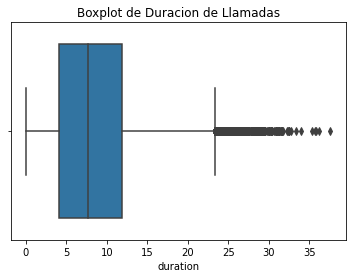

In [34]:
sns.boxplot(x=calls['duration'])
plt.title('Boxplot de Duracion de Llamadas')
plt.show()

In [35]:
Q1 = calls['duration'].quantile(0.25)
Q3 = calls['duration'].quantile(0.75)
IQR = Q3 - Q1
print('Q1: ', Q1)
print('Q3: ', Q3)
print('IQR: ', IQR)

Q1:  4.15
Q3:  11.82
IQR:  7.67


In [36]:
bottom_cutoff = Q1 - (1.5*IQR)
top_cutoff = Q3 + 1.5 * IQR
if bottom_cutoff < 0:
    bottom_cutoff = 0
print('min: ',bottom_cutoff)
print('max: ',top_cutoff)

min:  0
max:  23.325


In [37]:
calls_outliers = calls.query('duration > @top_cutoff')
len(calls_outliers) / len(calls) * 100

0.8187482529463216

- El límite máximo de duración de una llamada es de 23 minutos aprox, y al parecer menos del 1% de los usuarios, hacen llamadas de una duración superior a ese límite.

In [38]:
calls.sample(10)

,id,user_id,call_date,duration,day,month,year
18254,107037,1070,2018-12-28,15.31,Friday,12,2018
54753,1196646,1196,2018-12-31,2.24,Monday,12,2018
93071,1334439,1334,2018-09-22,8.19,Saturday,9,2018
73985,12629,1262,2018-12-22,1.35,Saturday,12,2018
87693,1321459,1321,2018-12-24,0.51,Monday,12,2018
8049,1038160,1038,2018-11-06,2.66,Tuesday,11,2018
121719,1428116,1428,2018-11-08,8.65,Thursday,11,2018
102976,1365172,1365,2018-11-21,7.17,Wednesday,11,2018
80289,1289189,1289,2018-11-24,12.33,Saturday,11,2018
844,1004368,1004,2018-08-18,2.56,Saturday,8,2018


## Mensajes

In [39]:
# Imprime la información/resumen general sobre el DataFrame de los mensajes
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  int64         
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.7 MB


- message_data fue modificado inicialmente de object a datetime

In [40]:
# Imprime una muestra de datos para los mensajes
messages.head(10)

,id,user_id,message_date
0,1000125,1000,2018-12-27
1,1000160,1000,2018-12-31
2,1000223,1000,2018-12-31
3,1000251,1000,2018-12-27
4,1000255,1000,2018-12-26
5,1000346,1000,2018-12-29
6,1000386,1000,2018-12-30
7,1000413,1000,2018-12-31
8,1000502,1000,2018-12-27
9,1000525,1000,2018-12-28


### Corregir datos

In [41]:
messages.describe(include='all')

/tmp/ipykernel_121/2236176242.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  messages.describe(include='all')


,id,user_id,message_date
count,7.605100e+04,76051.000000,76051
unique,NaN,NaN,351
top,NaN,NaN,2018-12-28 00:00:00
freq,NaN,NaN,702
first,NaN,NaN,2018-01-15 00:00:00
last,NaN,NaN,2018-12-31 00:00:00
mean,1.087230e+06,1245.972768,NaN
std,1.685300e+06,139.843635,NaN
min,1.001100e+04,1000.000000,NaN
25%,1.347735e+05,1123.000000,NaN


### Enriquecer datos

In [42]:
messages.isna().sum()

id              0
user_id         0
message_date    0
dtype: int64

In [43]:
messages.duplicated().sum()

0

In [44]:
messages['id'].nunique() == len(messages)

True

In [45]:
messages['user_id'].nunique()

402

- Existen 402 usuarios unicos utilizando o enviando mensajes de texto

## Internet

In [46]:
# Imprime la información/resumen general sobre el DataFrame de los mensajes
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  int64         
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.2 MB


session_date de igual manera fue modificado a datetime

In [47]:
# Imprime una muestra de datos para el tráfico de internet
internet.head(10)

,id,user_id,session_date,mb_used
0,100013,1000,2018-12-29,89.86
1,1000204,1000,2018-12-31,0.00
2,1000379,1000,2018-12-28,660.40
3,1000413,1000,2018-12-26,270.99
4,1000442,1000,2018-12-27,880.22
5,10010,1001,2018-08-24,284.68
6,10013,1001,2018-12-09,656.04
7,10014,1001,2018-11-04,16.97
8,100110,1001,2018-11-27,135.18
9,100115,1001,2018-12-13,761.92


In [48]:
internet.describe(include='all')

/tmp/ipykernel_121/2759054158.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  internet.describe(include='all')


,id,user_id,session_date,mb_used
count,1.048250e+05,104825.000000,104825,104825.000000
unique,NaN,NaN,351,NaN
top,NaN,NaN,2018-12-24 00:00:00,NaN
freq,NaN,NaN,851,NaN
first,NaN,NaN,2018-01-15 00:00:00,NaN
last,NaN,NaN,2018-12-31 00:00:00,NaN
mean,8.700316e+05,1242.496361,NaN,366.713701
std,5.403356e+05,142.053913,NaN,277.170542
min,1.001000e+04,1000.000000,NaN,0.000000
25%,1.373880e+05,1122.000000,NaN,136.080000


In [49]:
internet.isna().sum()

id              0
user_id         0
session_date    0
mb_used         0
dtype: int64

In [50]:
internet.duplicated().sum()

0

In [51]:
internet['id'].nunique() == len(internet)

True

In [52]:
internet['user_id'].nunique()

489

- Existen 489 usuarios unicos que utilizan servicios de internet

### Corregir datos

In [53]:
internet['mb_used'].value_counts()

0.00      13747
414.46        8
435.77        8
423.06        7
313.79        7
          ...  
301.21        1
108.62        1
608.63        1
212.02        1
677.66        1
Name: mb_used, Length: 57624, dtype: int64

- Voy a eliminar las sesiones de internet con 0 mb utilizados ya que no reflejan el uso

In [54]:
len(internet.loc[internet['mb_used']==0]) / len(internet) * 100

13.11423801574052

- 13.11% de 0 mb_used será removido

In [55]:
internet = internet.loc[internet['mb_used']>0]

- Checkeo los outliers de los mb_usados

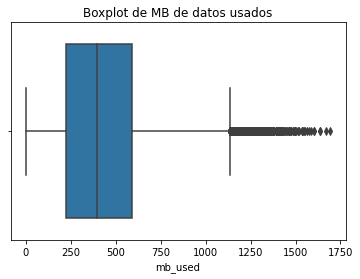

In [56]:
sns.boxplot(x=internet['mb_used'])
plt.title('Boxplot de MB de datos usados')
plt.show()

In [57]:
Q1 = internet['mb_used'].quantile(0.25)
Q3 = internet['mb_used'].quantile(0.75)
IQR = Q3 - Q1
print('Q1: ', Q1)
print('Q3: ', Q3)
print('IQR: ', IQR)

bottom_cutoff = Q1 - (1.5*IQR)
top_cutoff = Q3 + 1.5 * IQR
if bottom_cutoff < 0:
    bottom_cutoff = 0
print('min: ',bottom_cutoff)
print('max: ',top_cutoff)

Q1:  223.38
Q3:  588.3675000000001
IQR:  364.98750000000007
min:  0
max:  1135.84875


In [58]:
internet_outliers = internet.query('mb_used > @top_cutoff')
len(internet_outliers) / len(internet) * 100

0.7158699137003448

- Un pequeño porcentaje de usuarios, menos del 1%, utilizan una cantidad de datos de avegación inusualmente alta. Estos valores atípicos son positivos, ya que pueden generar ingresos adicionales para la empresa. El máximo es de 1135 mb.

In [59]:
calls['duration'] = np.ceil(calls['duration']).astype(int)
internet['gb_used'] = np.ceil(internet['mb_used']).astype(int)

- Finalmente redondeo no solo los mb utilizados sino tambien la duración de las llamadas

CONCLUSIONES INICIALES

- Se tuvieron que modificar un par de categorías, las cuales fueron mencionadas anteriormente.

- La duración mínima de la llamada es 0. Esto podría ser una llamada perdida si la duración es inferior a 0,1 segundos.

- Hay 481 usuarios únicos que hicieron llamadas.

- Es posible que la columna mb_used tenga un valor de 0. Esto podría deberse a que los usuarios están utilizando Wi-Fi en lugar de datos de navegación.

- Hay 489 usuarios únicos que utilizaron Internet.

- Hay 402 usuarios únicos que enviaron mensajes.

- El 6,8 % de los clientes (34 clientes) abandonaron el servicio. El 93,2 % de los clientes (466 clientes) no abandonaron el servicio.

- La columna de user_id es única. Hay un total de 500 ID de usuario únicos, pero no todos los utilizaron los servicios.

In [60]:
# Calcula el número de llamadas hechas por cada usuario por mes. Guarda el resultado.
calls_usage = calls.groupby(['user_id','month']).agg({'duration':'sum','id':'count'}).rename(columns={'duration':'Minutes Used per month','id':'Calls Made'})
calls_usage


Minutes Used per month  Calls Made
user_id month                                    
1000    12                        124          16
1001    8                         182          22
        9                         315          38
        10                        393          47
        11                        426          49
...                               ...         ...
1498    12                        339          32
1499    9                         346          35
        10                        385          41
        11                        308          39
        12                        496          56

[2256 rows x 2 columns]

In [61]:
# Calcula el número de mensajes enviados por cada usuario por mes. Guarda el resultado.
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
messages_usage = messages.groupby(['user_id','month']).agg({'id':'count'}).rename(columns={'id':'SMS per month'})
messages_usage

SMS per month
user_id month               
1000    12                11
1001    8                 30
        9                 44
        10                53
        11                36
...                      ...
1496    9                 21
        10                18
        11                13
        12                11
1497    12                50

[1806 rows x 1 columns]

In [62]:
# Calcula el volumen del trafico de internet usado por cada usuario por mes. Guarda el resultado.
internet['month'] = pd.DatetimeIndex(internet['session_date']).month


In [63]:
internet_usage_mb = internet.groupby(['user_id','month']).agg({'mb_used':'sum'}).rename(columns={'mb_used':'Data used per month in mb'})
internet_usage_mb

Data used per month in mb
user_id month                           
1000    12                       1901.47
1001    8                        6919.15
        9                       13314.82
        10                      22330.49
        11                      18504.30
...                                  ...
1498    12                      23137.69
1499    9                       12984.76
        10                      19492.43
        11                      16813.83
        12                      22059.21

[2277 rows x 1 columns]

In [64]:
internet_usage = np.ceil(internet.groupby(['user_id','month'])['mb_used'].sum()/1024).astype(int).to_frame().rename(columns={'mb_used':'Data used per month in gb'})
internet_usage

Data used per month in gb
user_id month                           
1000    12                             2
1001    8                              7
        9                             14
        10                            22
        11                            19
...                                  ...
1498    12                            23
1499    9                             13
        10                            20
        11                            17
        12                            22

[2277 rows x 1 columns]

In [65]:
user_plan = users[['user_id','plan']]
user_plan

,user_id,plan
0,1000,ultimate
1,1001,surf
2,1002,surf
3,1003,surf
4,1004,surf
...,...,...
495,1495,surf
496,1496,surf
497,1497,ultimate
498,1498,surf


In [66]:
# Combina los datos para las llamadas, minutos, mensajes e internet con base en el user_id y el mes
users_usage = pd.concat([calls_usage, messages_usage, internet_usage], axis=1).reset_index()
users_usage

,user_id,month,Minutes Used per month,Calls Made,SMS per month,Data used per month in gb
0,1000,12,124.0,16.0,11.0,2.0
1,1001,8,182.0,22.0,30.0,7.0
2,1001,9,315.0,38.0,44.0,14.0
3,1001,10,393.0,47.0,53.0,22.0
4,1001,11,426.0,49.0,36.0,19.0
...,...,...,...,...,...,...
2288,1498,12,339.0,32.0,NaN,23.0
2289,1499,9,346.0,35.0,NaN,13.0
2290,1499,10,385.0,41.0,NaN,20.0
2291,1499,11,308.0,39.0,NaN,17.0


In [67]:
users_usage = users_usage.merge(user_plan, on='user_id')
users_usage.columns= ['user_id','month','minutes','calls','sms','gb_used','plan']

In [68]:
users_usage

,user_id,month,minutes,calls,sms,gb_used,plan
0,1000,12,124.0,16.0,11.0,2.0,ultimate
1,1001,8,182.0,22.0,30.0,7.0,surf
2,1001,9,315.0,38.0,44.0,14.0,surf
3,1001,10,393.0,47.0,53.0,22.0,surf
4,1001,11,426.0,49.0,36.0,19.0,surf
...,...,...,...,...,...,...,...
2288,1498,12,339.0,32.0,NaN,23.0,surf
2289,1499,9,346.0,35.0,NaN,13.0,surf
2290,1499,10,385.0,41.0,NaN,20.0,surf
2291,1499,11,308.0,39.0,NaN,17.0,surf


- Creo que no he eliminado outliers, solo he tratado de identificar outliers en una variable según el método de Q1, Q3 e IQR. También creé nuevos dataframes 'calls_outliers' e 'internet_outliers', para ver específicamente las filas outliers, pero no modifico ni quito datos de los dataframe originales.

- Entiendo que los outliers en los boxplots de "mb_used" y "duration" podrían ser valores reales y no errores en los datos. Algunos usuarios pueden realmente usar muchos más datos o hablar mucho más tiempo que la mayoría (es normal).

- Al analizar los outliers no son errores, no están correlacionados con el pago, y no afectan el modelo predictivo de pago. 







- Si estoy equivocado o confundido, porfavor corrígeme. Gracias!

In [69]:
# Calcula el ingreso mensual para cada usuario
user_plan = users[['user_id','plan']]
user_plan

,user_id,plan
0,1000,ultimate
1,1001,surf
2,1002,surf
3,1003,surf
4,1004,surf
...,...,...
495,1495,surf
496,1496,surf
497,1497,ultimate
498,1498,surf


In [70]:
users_usage.isnull().sum()

user_id      0
month        0
minutes     37
calls       37
sms        487
gb_used     16
plan         0
dtype: int64

In [71]:
users_usage = users_usage.fillna(0)

-Relleno los valores faltantes con 0

In [72]:
plans.head(10)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [73]:
plans.query('plan_name == "ultimate"').loc[:,'messages_included'].values[0]

1000

- PLAN SURF

In [74]:
surf_price = plans.query('plan_name =="surf"').loc[:,'usd_monthly_pay'].values[0]
surf_messages = plans.query('plan_name =="surf"').loc[:,'messages_included'].values[0]
surf_data = (plans.query('plan_name =="surf"').loc[:,'mb_per_month_included'].values[0]/1024).astype('int')
surf_minutes = plans.query('plan_name =="surf"').loc[:,'minutes_included'].values[0]
surf_price_for_gb = plans.query('plan_name =="surf"').loc[:,'usd_per_gb'].values[0]
surf_price_for_message =  plans.query('plan_name =="surf"').loc[:,'usd_per_message'].values[0]
surf_price_for_minute = plans.query('plan_name =="surf"').loc[:,'usd_per_minute'].values[0]

- PLAN ULTIMATE

In [75]:
ultimate_price = plans.query('plan_name =="ultimate"').loc[:,'usd_monthly_pay'].values[0] 
ultimate_messages = plans.query('plan_name == "ultimate"').loc[:,'messages_included'].values[0]
ultimate_data = (plans.query('plan_name =="ultimate"').loc[:,'mb_per_month_included'].values[0]/1024).astype('int')
ultimate_minutes = plans.query('plan_name =="ultimate"').loc[:,'minutes_included'].values[0]
ultimate_price_for_gb = plans.query('plan_name =="ultimate"').loc[:,'usd_per_gb'].values[0]
ultimate_price_for_message = plans.query('plan_name =="ultimate"').loc[:,'usd_per_message'].values[0]
ultimate_price_for_minute = plans.query('plan_name =="ultimate"').loc[:,'usd_per_minute'].values[0]

In [76]:
print(f"Precio plan Surf: ${surf_price} mensual")
print(f"Mensajes plan Surf:{surf_messages} mensajes/textos")
print(f"Data plan Surf:{surf_data} GB por mes")
print(f"Minutos plan Surf:{surf_minutes} minutos")
print(f"Precio por GB plan Surf:${surf_price_for_gb} ") 
print(f"Precio por mensaje/texto plan Surf:${surf_price_for_message} ")
print(f"Precio por minuto plan Surf:${surf_price_for_minute} ")

Precio plan Surf: $20 mensual
Mensajes plan Surf:50 mensajes/textos
Data plan Surf:15 GB por mes
Minutos plan Surf:500 minutos
Precio por GB plan Surf:$10 
Precio por mensaje/texto plan Surf:$0.03 
Precio por minuto plan Surf:$0.03 


In [77]:
print(f"Precio plan Ultimate: ${ultimate_price} mensual")
print(f"Mensajes plan Ultimate:{ultimate_messages} mensajes/textos")
print(f"Data plan Ultimate:{ultimate_data} GB por mes")
print(f"Minutos plan Ultimate:{ultimate_minutes} minutos")
print(f"Precio por GB plan Ultimate:${ultimate_price_for_gb} ") 
print(f"Precio por mensaje/texto plan Ultimate:${ultimate_price_for_message} ")
print(f"Precio por minuto plan Ultimate:${ultimate_price_for_minute} ")

Precio plan Ultimate: $70 mensual
Mensajes plan Ultimate:1000 mensajes/textos
Data plan Ultimate:30 GB por mes
Minutos plan Ultimate:3000 minutos
Precio por GB plan Ultimate:$7 
Precio por mensaje/texto plan Ultimate:$0.01 
Precio por minuto plan Ultimate:$0.01 


In [78]:
def revenue(row):
    gb_used = row['gb_used']
    plan = row['plan']
    minutes = row['minutes']
    messages = row['sms']
    total_gb = 0
    total_messages = 0 
    total_minutes = 0
    if plan == 'surf':
        if gb_used > surf_data:
            total_gb = (gb_used - surf_data) * surf_price_for_gb
        if minutes > surf_minutes:
            total_minutes = (minutes - surf_minutes) * surf_price_for_minute
        if messages > surf_messages:
            total_messages = (messages - surf_messages) * surf_price_for_message
        
        return total_gb + total_minutes + total_messages + surf_price

    else: 
        if gb_used > ultimate_data:
            total_gb = (gb_used - ultimate_data) * ultimate_price_for_gb
        if minutes > ultimate_minutes:
            total_minutes = (minutes - ultimate_minutes) * ultimate_price_for_minute
        if messages > ultimate_messages:
            total_messages = (messages - ultimate_messages) * ultimate_price_for_message
        return total_gb + total_minutes + total_messages + ultimate_price

In [79]:
users_usage['revenue'] = users_usage.apply(revenue, axis=1)

In [80]:
users_usage.head(10)

,user_id,month,minutes,calls,sms,gb_used,plan,revenue
0,1000,12,124.0,16.0,11.0,2.0,ultimate,70.00
1,1001,8,182.0,22.0,30.0,7.0,surf,20.00
2,1001,9,315.0,38.0,44.0,14.0,surf,20.00
3,1001,10,393.0,47.0,53.0,22.0,surf,90.09
4,1001,11,426.0,49.0,36.0,19.0,surf,60.00
5,1001,12,412.0,46.0,44.0,19.0,surf,60.00
6,1002,10,59.0,8.0,15.0,7.0,surf,20.00
7,1002,11,386.0,48.0,32.0,19.0,surf,60.00
8,1002,12,384.0,38.0,41.0,15.0,surf,20.00
9,1003,12,1104.0,118.0,50.0,27.0,surf,158.12


In [81]:
users_usage.sample(5)

,user_id,month,minutes,calls,sms,gb_used,plan,revenue
389,1081,7,196.0,28.0,32.0,16.0,surf,30.00
2247,1491,7,463.0,47.0,64.0,8.0,surf,20.42
1707,1366,11,656.0,72.0,19.0,19.0,surf,64.68
2219,1483,10,490.0,57.0,6.0,14.0,surf,20.00
2138,1465,11,911.0,95.0,30.0,16.0,ultimate,70.00


- Cliente MAS rentable

In [82]:
users_usage.iloc[users_usage['revenue'].idxmax(),:]

user_id      1379
month          12
minutes    1103.0
calls       114.0
sms         126.0
gb_used      70.0
plan         surf
revenue    590.37
Name: 1756, dtype: object

- Cliente MENOS rentable

In [83]:
users_usage.iloc[users_usage['revenue'].idxmin(),:]

user_id     1001
month          8
minutes    182.0
calls       22.0
sms         30.0
gb_used      7.0
plan        surf
revenue     20.0
Name: 1, dtype: object

- Todos los demás usuarios con ingresos de menos rentabilidad

In [84]:
users_usage[users_usage['revenue']==20]

,user_id,month,minutes,calls,sms,gb_used,plan,revenue
1,1001,8,182.0,22.0,30.0,7.0,surf,20.0
2,1001,9,315.0,38.0,44.0,14.0,surf,20.0
6,1002,10,59.0,8.0,15.0,7.0,surf,20.0
8,1002,12,384.0,38.0,41.0,15.0,surf,20.0
10,1004,5,193.0,19.0,7.0,7.0,surf,20.0
...,...,...,...,...,...,...,...,...
2272,1496,8,122.0,14.0,2.0,9.0,surf,20.0
2274,1496,10,317.0,35.0,18.0,14.0,surf,20.0
2275,1496,11,308.0,32.0,13.0,9.0,surf,20.0
2282,1498,6,238.0,29.0,0.0,15.0,surf,20.0


- Total de beneficio

In [85]:
users_usage['revenue'].sum()

147557.18

- Total de beneficio por plan

In [86]:
users_usage.groupby('plan')['revenue'].sum()

plan
surf        95491.18
ultimate    52066.00
Name: revenue, dtype: float64

CONCLUSIONES MEDIAS

- Convertí los tipos de datos de id a enteros. Después, cambié todos los caracteres de cadena a minúsculas.

- A continuación, utilicé groupby para obtener el número de llamadas realizadas y los minutos utilizados cada mes, el número de mensajes de texto enviados cada mes y el volumen de datos utilizado cada mes.

- Para calcular los ingresos mensuales de cada usuario, combiné todos los datos anteriores. Luego, busqué el plan de cada usuario y comprobé si utilizan más de lo que les corresponde en cada parámetro. Para calcular el exceso de uso, resté el límite del paquete gratuito del número total de llamadas, mensajes de texto y datos. Luego, multipliqué el resultado por el valor del plan de llamadas. Por último, añadí el cargo mensual del plan de llamadas.

- El usuario más rentable es el usuario con el ID 1379 que tiene el plan Surf, en el mes 12. Con una rentabilidad de 596.65 dólares.

- El total de benficio de la empresa asciende a 147,557.18 dólares.

- Los ingresos totales del plan Surf son de 95,491.18 y los del plan Ultimate son de 52,066 dólares.

## Estudia el comportamiento del usuario

### Llamadas

In [86]:
users['plan'].value_counts(normalize=True) * 100

surf        67.8
ultimate    32.2
Name: plan, dtype: float64

- Es mayor la cantidad de usuarios que eligieron el plan Surf en comparación al plan Ultimate. Casi 68% contra un 32%.

In [87]:
status = users_usage.groupby(['plan','month']).agg({'minutes':'sum','sms':'sum','gb_used':'sum'})
status

minutes      sms  gb_used
plan     month                            
surf     1         406.0     21.0     10.0
         2        2673.0    108.0    110.0
         3        7590.0    351.0    312.0
         4       17577.0    870.0    611.0
         5       30768.0   1849.0   1087.0
         6       41836.0   2454.0   1502.0
         7       54448.0   3271.0   2042.0
         8       66438.0   4662.0   2735.0
         9       80360.0   5968.0   3238.0
         10     101846.0   8020.0   4126.0
         11     119801.0   9165.0   4650.0
         12     150680.0  12275.0   5800.0
ultimate 1         774.0     62.0     29.0
         2        2822.0    151.0    121.0
         3        3651.0    243.0    221.0
         4        7074.0    463.0    343.0
         5       11781.0    931.0    489.0
         6       17435.0   1379.0    725.0
         7       25197.0   1937.0    973.0
         8       29922.0   2732.0   1267.0
         9       37626.0   3259.0   1463.0
         10      47778.0   4181.0   1878.0
         11      56540.0   4903.0   2174.0
         12      69324.0   6796.0   2778.0

In [88]:
users_usage_surf = users_usage.query('plan == "surf"')
users_usage_ultimate = users_usage.query('plan == "ultimate"')


In [89]:
surf_mins = status.xs('surf')['minutes'] 
ultimate_mins = status.xs('ultimate')['minutes']

In [90]:
# Calcula la media y la varianza de la duración mensual de llamadas.
users_usage.groupby(['plan'])['minutes'].agg([np.mean, np.var, np.std])

,mean,var,std
plan,,,
surf,428.749523,54968.279461,234.453150
ultimate,430.450000,57844.464812,240.508762


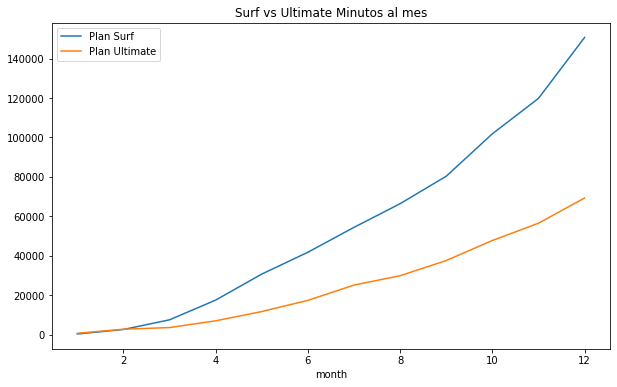

In [91]:
plt.figure(figsize=(10,6))
status.xs('surf')['minutes'].plot()
status.xs('ultimate')['minutes'].plot()
plt.legend(['Plan Surf', 'Plan Ultimate'])
plt.title('Surf vs Ultimate Minutos al mes')
plt.show()

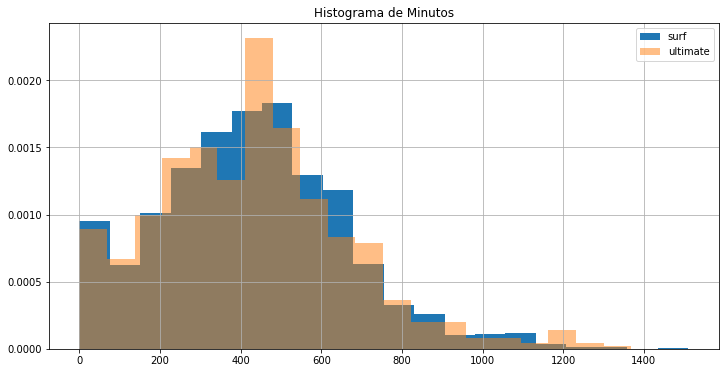

In [92]:
ax = users_usage_surf.hist(column='minutes',density=True, bins=20, figsize=(12,6))
users_usage_ultimate.hist(column='minutes',density=True, bins=20, alpha=0.5,ax =ax)
plt.legend(['surf','ultimate'])
plt.title('Histograma de Minutos')
plt.show()

### Mensajes

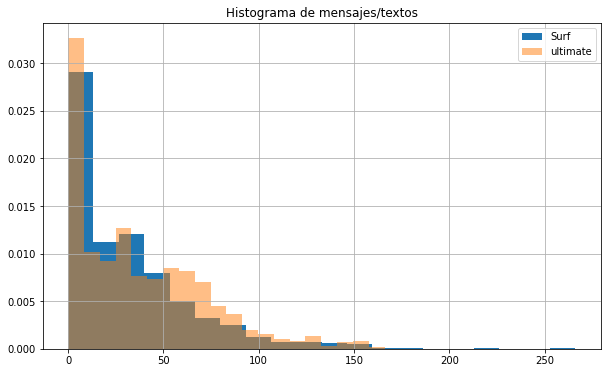

In [93]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
ax = users_usage_surf.hist(column='sms',density=True, bins=20, figsize=(10,6))
users_usage_ultimate.hist(column='sms',density=True, bins=20, alpha=0.5,ax =ax)
plt.legend(['Surf','ultimate'])
plt.title('Histograma de mensajes/textos')
plt.show()

In [94]:
users_usage.groupby(['plan'])['sms'].agg([np.mean, np.var, np.std])

,mean,var,std
plan,,,
surf,31.159568,1126.724522,33.566717
ultimate,37.551389,1208.756744,34.767179


### Internet

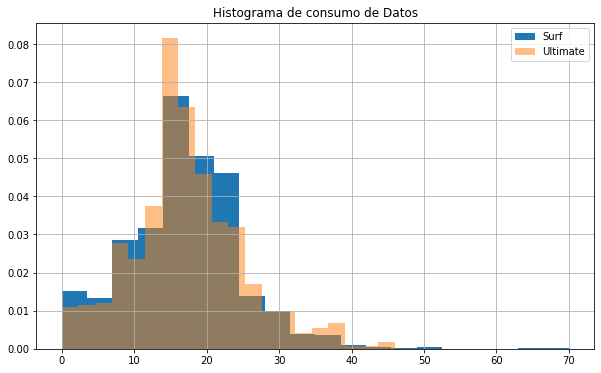

In [95]:
# Compara la cantidad de tráfico de internet consumido por usuarios por plan
ax = users_usage_surf.hist(column='gb_used',density=True, bins=20, figsize=(10,6))
users_usage_ultimate.hist(column='gb_used',density=True, bins=20, alpha=0.5,ax =ax)
plt.legend(['Surf','Ultimate'])
plt.title('Histograma de consumo de Datos')
plt.show()

In [96]:
users_usage.groupby(['plan'])['gb_used'].agg([np.mean, np.var, np.std])

,mean,var,std
plan,,,
surf,16.670693,61.58360,7.847522
ultimate,17.306944,58.83055,7.670108


In [97]:
users_usage_surf.head()

,user_id,month,minutes,calls,sms,gb_used,plan,revenue
1,1001,8,182.0,22.0,30.0,7.0,surf,20.00
2,1001,9,315.0,38.0,44.0,14.0,surf,20.00
3,1001,10,393.0,47.0,53.0,22.0,surf,90.09
4,1001,11,426.0,49.0,36.0,19.0,surf,60.00
5,1001,12,412.0,46.0,44.0,19.0,surf,60.00


In [98]:
users_usage_ultimate.head()

,user_id,month,minutes,calls,sms,gb_used,plan,revenue
0,1000,12,124.0,16.0,11.0,2.0,ultimate,70.0
19,1006,11,10.0,2.0,15.0,3.0,ultimate,70.0
20,1006,12,59.0,7.0,139.0,32.0,ultimate,84.0
26,1008,10,476.0,54.0,21.0,17.0,ultimate,70.0
27,1008,11,446.0,50.0,37.0,24.0,ultimate,70.0


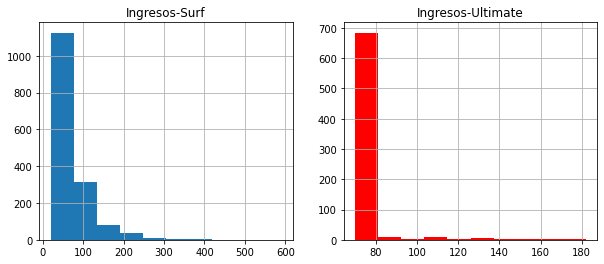

In [99]:
fig, axes = plt.subplots(1, 2)
users_usage_surf['revenue'].hist(ax=axes[0])
users_usage_ultimate['revenue'].hist(ax=axes[1], color='red',figsize=(10,4))
axes[0].set_title('Ingresos-Surf')
axes[1].set_title('Ingresos-Ultimate')
plt.show()

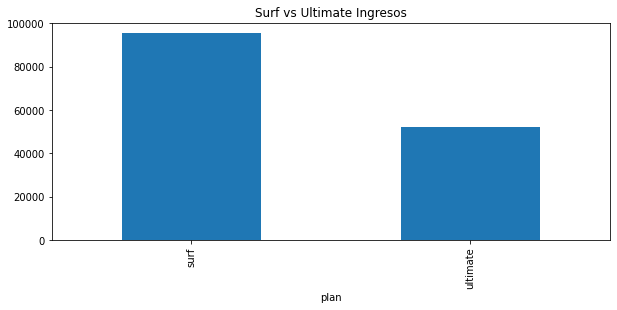

In [100]:
users_usage.groupby('plan')['revenue'].sum().plot(kind='bar', figsize=(10,4))
plt.title('Surf vs Ultimate Ingresos')
plt.show()

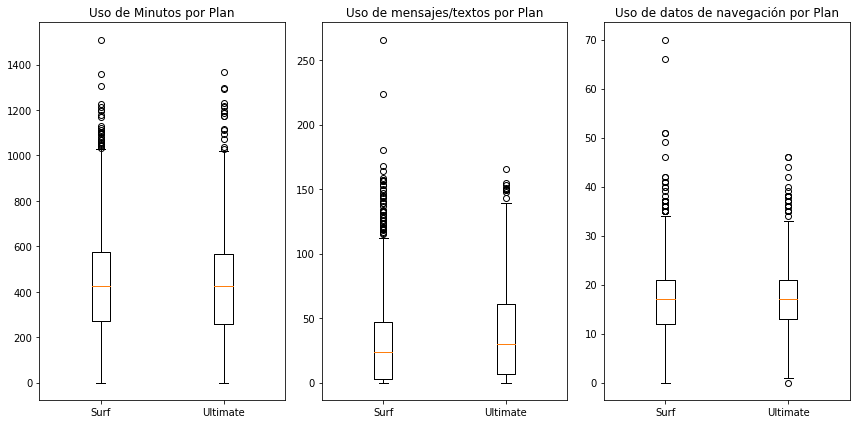

In [141]:
fig, axs = plt.subplots(1,3, figsize=(12,6))

axs[0].boxplot([users_usage_surf['minutes'], users_usage_ultimate['minutes']], labels=['Surf', 'Ultimate'])
axs[0].set_title('Uso de Minutos por Plan')

axs[1].boxplot([users_usage_surf['sms'], users_usage_ultimate['sms']], labels=['Surf', 'Ultimate'])  
axs[1].set_title('Uso de mensajes/textos por Plan')

axs[2].boxplot([users_usage_surf['gb_used'], users_usage_ultimate['gb_used']], labels=['Surf', 'Ultimate'])
axs[2].set_title('Uso de datos de navegación por Plan')

plt.tight_layout()
plt.show()

Al ver toda esta información puedo concluir de manera general que:

- Hay muchos más usuarios de Surf que de Ultimate.
- El uso de los servicios es similar en ambos planes, pero los usuarios de Surf tienden a usar más servicios cada mes.
- Los usuarios de Ultimate no utilizan mucho sus minutos (considerando que tiene un límite de 3000 mins y el promedio ronda a 400 mins) ni sus mensajes (ya que el promedio es de alrededor de 37 textos cuando tienen un límite 1000 mensajes), pero si utilizan una cantidad similar de datos de internet que los usuarios de Surf.
- El plan Surf genera más ingresos que el plan Ultimate porque tiene más usuarios.

## Probar las hipótesis estadísticas.

PRIMERA HIPÓTESIS
- Voy a probar la hipótesis de que el beneficio medio de los usuarios de los planes de llamadas Ultimate y Surf es diferente. Esta vez utilizaré la prueba de Levene.

In [101]:
# Prueba las hipótesis
prueba_surf = users_usage[users_usage['plan']=='surf']['revenue']
prueba_surf

1        20.00
2        20.00
3        90.09
4        60.00
5        60.00
         ...  
2288    100.00
2289     20.00
2290     70.00
2291     40.00
2292     90.00
Name: revenue, Length: 1573, dtype: float64

In [102]:
prueba_ultimate = users_usage[users_usage['plan']=='ultimate']['revenue']
prueba_ultimate

0       70.0
19      70.0
20      84.0
26      70.0
27      70.0
        ... 
2258    70.0
2259    70.0
2260    70.0
2261    70.0
2277    70.0
Name: revenue, Length: 720, dtype: float64

In [103]:
st.levene(prueba_surf, prueba_ultimate, center='mean')

LeveneResult(statistic=594.6026163420061, pvalue=5.915081558303153e-117)

- La prueba detrmina que los grupos de muestras no tienen la misma varianza. Esto significa que los datos no están dispersos de manera uniforme en los dos grupos.

In [104]:
prueba_surf.mean(), prueba_ultimate.mean()

(60.706408137317226, 72.31388888888888)

In [105]:
alpha = 0.05
results = st.ttest_ind(
        prueba_surf, 
        prueba_ultimate,equal_var=False)

print('p-value: ', results.pvalue)
#Because we have two tailed, we are dividing alpha which means we have 2.5% each side.
if (results.pvalue < alpha):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos ignorar la hipótesis nula")

p-value:  3.17039054811355e-15
Rechazamos la hipótesis nula


In [106]:
prueba_ultimate.mean() > prueba_surf.mean()

True

- Según la prueba de Levene, las varianzas de las dos muestras son diferentes. Esto significa que los datos no se distribuyen de manera uniforme en las dos muestras.
- Con un nivel de confianza del 95 %, podemos concluir que el promedio de ingresos de los usuarios de surf no es igual al de los usuarios de ultimate. Esto significa que los usuarios de Ultimate generan más ingresos que los usuarios de Surf.

SEGUNDA HIPÓTESIS

- La hipótesis será nula si el promedio de ingresos de los usuarios de NY-NJ ES IGUAL al de los usuarios de otras regiones.
- Será la hipótesis alternativa si el promedio de ingresos de los usuarios de NY-NJ NO ES IGUAL al de los usuarios de otras regiones.
- El nivel de confianza es del 95 % y el alfa es de 0,05.

In [107]:
# Prueba las hipótesis
users['city'].value_counts()

new york-newark-jersey city, ny-nj-pa msa          80
los angeles-long beach-anaheim, ca msa             29
dallas-fort worth-arlington, tx msa                21
chicago-naperville-elgin, il-in-wi msa             19
philadelphia-camden-wilmington, pa-nj-de-md msa    17
                                                   ..
oxnard-thousand oaks-ventura, ca msa                1
jacksonville, fl msa                                1
albany-schenectady-troy, ny msa                     1
greensboro-high point, nc msa                       1
cape coral-fort myers, fl msa                       1
Name: city, Length: 73, dtype: int64

In [108]:
is_ny_nj = users['city'].apply(lambda x: True if 'ny-nj' in x else False)
ny_nj = users[is_ny_nj]['user_id'].values.tolist()

In [109]:
prueba_ny_nj = users_usage[users_usage['user_id'].isin(ny_nj)]['revenue']
otros_prueba = users_usage[~users_usage['user_id'].isin(ny_nj)]['revenue']

In [110]:
prueba_ny_nj.mean(), otros_prueba.mean()

(59.921352785145885, 65.2227713987474)

In [111]:
st.levene(prueba_ny_nj, otros_prueba, center='mean')

LeveneResult(statistic=1.8415947578436047, pvalue=0.17489782767369766)

- El valor p de la prueba fue mayor que el umbral de 0,05, por lo que no hay evidencia suficiente para decir que los grupos de muestras tienen varianza desigual. En otras palabras, los datos parecen estar dispersos de manera uniforme en los dos grupos.

In [112]:
alpha = 0.05
results = st.ttest_ind(prueba_ny_nj, otros_prueba,equal_var=True)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos ignorar la hipótesis nula")

p-value:  0.043557431621342436
Rechazamos la hipótesis nula


- La prueba de Levene determina que los usuarios de NY-NJ y los usuarios de otras regiones tienen la misma varianza. Esto significa que los datos están dispersos de manera uniforme en los dos grupos. Con un nivel de confianza del 95 %, puedo concluir que los usuarios de otras regiones generan más ingresos que los usuarios de NY-NJ.

CONCLUSIONES FINALES

Como Analista de Megaline puedo concluir que:
- Los usuarios de NY-NJ son menos rentables que los de otras regiones. Esto puede deberse a que los usuarios de NY-NJ utilizan sus servicios menos que los usuarios de otras regiones.

- Los usuarios de Surf utilizan sus servicios más que los usuarios de Ultimate, lo que significa que están obteniendo un mejor valor por su dinero.

- Los usuarios de Ultimate no utilizan sus servicios al máximo, lo que significa que podrían estar pagando más de lo que deberían.

- Fué muy notorio que el plan Surf es el más popular (probablemente por el precio), ya que hay más usuarios de Surf que de Ultimate.

- El usuario más rentable es un usuario del plan Surf, pero el usuario menos rentable también es un usuario del plan Surf. Esto significa que hay una gran variación en los ingresos de los usuarios del plan Surf.

<div class="alert alert-block alert-success">
    
# Comentarios generales #3
    
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Todo ha sido corregido. Has aprobado un nuevo proyecto. ¡Felicitaciones!
</div>